In [1]:
'''
Rohan's version 
train.ipynb 
9/2/2020 

'''
import argparse
import collections
from pathlib import Path
import csv
import os 

import numpy as np 

import torch
import torch.optim as optim
from torchvision import transforms, utils as vision_utils 
#from torch.utils.tensorboard import SummaryWriter

from retinanet import model
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer, BalancedSampler
from torch.utils.data import DataLoader

from retinanet.sampler import SamplerFactory, aggregate_indices_per_class 


from retinanet import coco_eval
from retinanet import csv_eval

assert torch.__version__.split('.')[0] == '1'



/pasteur/u/egoodma/MINICONDA/envs/actionshandstools/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/pasteur/u/egoodma/MINICONDA/envs/actionshandstools/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


In [2]:
MODELS_DIR = '/pasteur/u/egoodma/new-tools/surgery-tool-detection/models/'
LOGS_DIR = '/pasteur/u/egoodma/new-tools/surgery-tool-detection/logs/'

##MODELS_DIR = str(Path(__file__).resolve().parents[2]) + '/models/'
##LOGS_DIR = str(Path(__file__).resolve().parents[2]) + '/logs/'
# pretrained_model = MODELS_DIR + 'coco_resnet_50_map_0_335_state_dict.pt'

print('CUDA available: {}'.format(torch.cuda.is_available()))

CUDA available: True


## Set up model configs

In [3]:
### Set up model configs ### 

parser = argparse.ArgumentParser(description='Simple training script for training a RetinaNet network.')

parser.add_argument('--dataset', help='Dataset type, must be one of csv or coco.')
parser.add_argument('--coco_path', help='Path to COCO directory')
parser.add_argument('--csv_train', help='Path to file containing training annotations (see readme)')
parser.add_argument('--csv_classes', help='Path to file containing class list (see readme)')
parser.add_argument('--csv_val', help='Path to file containing validation annotations (optional, see readme)')

parser.add_argument('--depth', help='Resnet depth, must be one of 18, 34, 50, 101, 152', type=int, default=50)
parser.add_argument('--epochs', help='Number of epochs', type=int, default=100)
parser.add_argument('--model_name', help='Name to store the trianed model under.')
parser.add_argument('--log_output', help='Save output to csv file', action='store_true')
parser.add_argument('--batch_size', type=int)
parser.add_argument('--learning_rate', type=float)
parser.add_argument('--threshold', help='iou threshold to count as detection')
parser.add_argument('--sampler', help='Type of sampler to use, default aspect ratio sampler.')
parser.add_argument('--augment', action='store_true')
parser.add_argument('--pretrained', help='Path to pretrained model')
parser.add_argument('--blacken', action='store_true')

#parser = parser.parse_args(args)


##### PRIMARY MODEL CONFIGS TO SET ### 

parser.model_name = '9.21_Model2' 

parser.augment = 0.9 #1.0 #0.7 #False 
parser.pipeline = 'my_pipeline_v3' #"kitchen_sink" #"my_pipeline_v3" #"rotate" #"my_pipeline_v1" #False 

#parser.sampler = None 
#parser.sampler = "old balanced (no alpha)" 
parser.sampler = 'new balanced' 
parser.alpha = 0.9  

parser.depth = 50 
parser.epochs = 60  
parser.num_workers = 3

##### END PRIMARY CONFIGS ######## 



parser.log_output = True 
LOG_DIR = LOGS_DIR + parser.model_name + '/'
os.makedirs(LOG_DIR, exist_ok=True) 

parser.dataset = 'csv' 
parser.csv_train = '/pasteur/u/egoodma/surgery-tool-detection/src/data/train_data.csv' #'../data/train_data.csv'
parser.csv_val = '/pasteur/u/egoodma/surgery-tool-detection/src/data/val_data.csv' #../val_data.csv 
parser.csv_classes = '/pasteur/u/egoodma/surgery-tool-detection/src/data/class_names.csv' #../data/class_names.csv 


parser.blacken = False 
parser.learning_rate = None 

parser.batch_size = None ## Set and log config? 
parser.threshold = None ## Set and log config? 



configs = ['model_name', 'augment', 'pipeline', 'sampler', 'alpha', 'depth', 'epochs', 'num_workers'] #, log_output, dataset, csv_train] 

filename = '{}_configs.txt'.format(LOG_DIR + parser.model_name) 
config_log = open(filename, 'w') 

for config in configs: 
    value = getattr(parser, config) 
    output_line = '{}: {}\n'.format(config, value) 
    print(output_line) 
    config_log.write(output_line) 

config_log.close() 

model_name: 9.21_Model2

augment: 0.9

pipeline: my_pipeline_v3

sampler: new balanced

alpha: 0.9

depth: 50

epochs: 60

num_workers: 3



## Set up dataloaders, model, logging 

In [4]:
model_name = 'model'
if parser.model_name is not None:
    model_name = parser.model_name

learning_rate = 1e-5
if parser.learning_rate is not None:
    learning_rate = float(parser.learning_rate)

batch_size = 2
if parser.batch_size is not None:
    batch_size = int(parser.batch_size)

threshold = 0.5
if parser.threshold is not None:
    threshold = float(parser.threshold)

In [5]:
# Create the dataloaders     

if parser.dataset == 'coco':

    if parser.coco_path is None:
        raise ValueError('Must provide --coco_path when training on COCO,')

    dataset_train = CocoDataset(parser.coco_path, set_name='train2017',
                                transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
    dataset_val = CocoDataset(parser.coco_path, set_name='val2017',
                              transform=transforms.Compose([Normalizer(), Resizer()]))

elif parser.dataset == 'csv':

    if parser.csv_train is None:
        raise ValueError('Must provide --csv_train when training on COCO,')

    if parser.csv_classes is None:
        raise ValueError('Must provide --csv_classes when training on COCO,')

    dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                               transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]), 
                               augment=parser.augment, pipeline=parser.pipeline, blacken=parser.blacken)
    train_acc_set = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                               transform=transforms.Compose([Normalizer(), Resizer()]), blacken=parser.blacken)

    if parser.csv_val is None:
        dataset_val = None
        print('No validation annotations provided.')
    else:
        dataset_val = CSVDataset(train_file=parser.csv_val, class_list=parser.csv_classes,
                                 transform=transforms.Compose([Normalizer(), Resizer()]))

else:
    raise ValueError('Dataset type not understood (must be csv or coco), exiting.')
    


sampler = AspectRatioBasedSampler(dataset_train, batch_size=batch_size, drop_last=False)
if parser.sampler is not None and parser.sampler == 'old balanced (no alpha)':
    sampler = BalancedSampler(dataset_train, batch_size=batch_size, drop_last=False) 
if parser.sampler is not None and parser.sampler == 'new balanced': 
    class_indices_dict = aggregate_indices_per_class(dataset_train) 
    class_indices = list(class_indices_dict.values()) 
    # for label in class_indices: print(len(label))
    #batch_sz = 2 
    # print("Hello") 
    # print(len(dataset_train)//batch_sz) 
    sampler = SamplerFactory().get(
        class_idxs=class_indices,
        batch_size=batch_size,
        n_batches=len(dataset_train)//batch_size,
        alpha=parser.alpha,
        kind='random'
    ) 
    
    
dataloader_train = DataLoader(dataset_train, num_workers=parser.num_workers, collate_fn=collater, batch_sampler=sampler) 
#dataloader_train = DataLoader(dataset_val, num_workers=parser.num_workers, collate_fn=collater, batch_sampler=sampler) 


if dataset_val is not None:
    sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
    dataloader_val = DataLoader(dataset_val, num_workers=parser.num_workers, collate_fn=collater, batch_sampler=sampler_val)



Using new Balanced Sampler


2450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
torch.Size([608, 1056, 3])


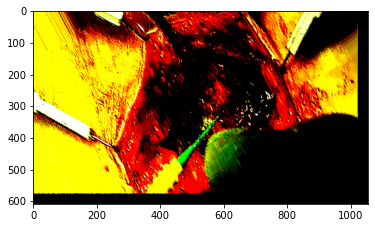

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


430
0
torch.Size([608, 1056, 3])


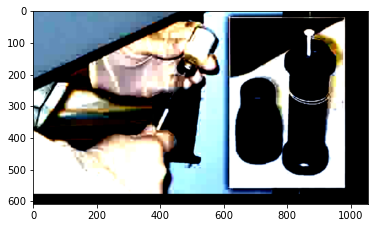

In [6]:
# Observe dataset 

# Make sure augmentations are being preserved in the dataset! 
# And this iterates in order so can see how augmentation changes as you run the pipeline over and over 


import matplotlib.pyplot as plt 
import cv2 
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    UnNormalizer, Normalizer
unnormalize = UnNormalizer()

# print(len(dataset_train.image_data)) 
# print(len(dataset_val.image_data)) 

print(len(dataset_train)) 

for idx, sample in enumerate(dataset_train): 
    
    print(idx) 
    print(sample['img'].shape)  
    image = sample['img'] 
    plt.imshow(image) 
    plt.show() 
    
    if idx == 0: break 
        
        
print(len(dataset_val)) 

for idx, sample in enumerate(dataset_val): 
    
    print(idx) 
    print(sample['img'].shape)  
    image = sample['img'] 
    plt.imshow(image) 
    plt.show() 
    
    if idx == 0: break 

Using new Balanced Sampler
0
rmcomZXiud4-000001259.jpg
rmcomZXiud4
1
index:  346


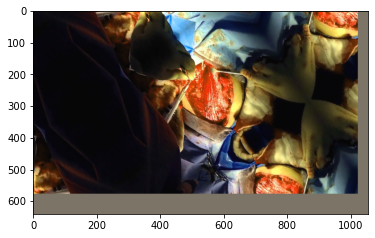

i2GvmqhU4og-000002927.jpg
i2GvmqhU4og
1
index:  1539


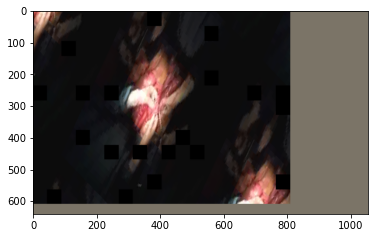

1
ZP58Wx0QaWE-000001028.jpg
ZP58Wx0QaWE
1
index:  1204
bovie


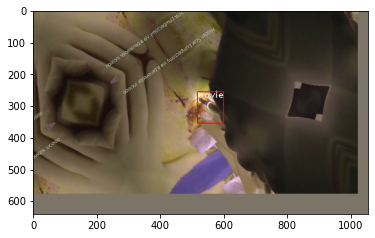

dBRV4qa_qxk-000001016.jpg
dBRV4qa_qxk
1
index:  2320


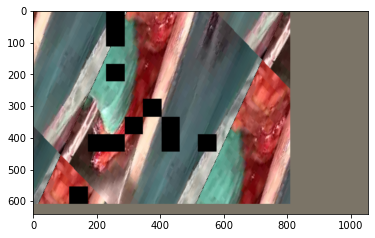

2
Mp2m1AMx8Ks-000000993.jpg
Mp2m1AMx8Ks
1
index:  2084
bovie


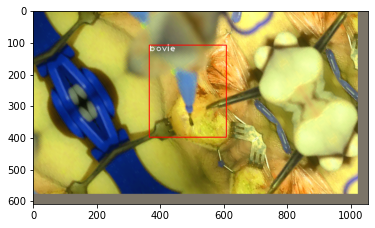

EUdac6A9n60-000004511.jpg
EUdac6A9n60
0
index:  945
needledriver
needledriver


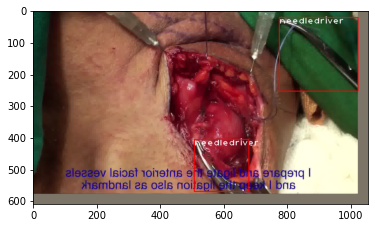

In [7]:
### Observe dataloader (Playing around cell)

# Check dataloader 
# Check dataloader augmentations: pipeline + frequency 
# Check dataloader batch logging properties like filename, vidID, tools present 
# Check dataloader sampling logic (over/undersampling) 

import matplotlib.pyplot as plt 
import cv2 
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    UnNormalizer, Normalizer

unnormalize = UnNormalizer()

def draw_caption(image, box, caption): 
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        

from collections import defaultdict 
from retinanet.train_utils import BatchLogger 


batchLogger = BatchLogger()      

batchLogger.index = {} 
class_indices_dict = aggregate_indices_per_class(dataset_train) 
# for class_, idxs in class_indices_dict.items(): 
#     idxdict = dict.fromkeys(idxs, [0, 0])  
#     batchLogger.index[class_] = idxdict 

for class_, idxs in class_indices_dict.items(): 
    idxdict = {idx : [0, 0] for idx in idxs} 
    batchLogger.index[class_] = idxdict
    
#print(batchLogger.index) 

# print(len(dataloader_train)) 
# print(len(dataloader_val)) 


for idx, data in enumerate(dataloader_train): 
    #if idx > 10: break 
    if idx > 2: break
    print(idx) 
#     print(data) 
#     print(len(data['img'])) 
#     print(len(data['annot'])) 
#     print(data['img'][0]) 
#     plt.imshow(data['img'][0]) 
#     plt.show() 
#     print(data) 
#     print(data['img'].shape) 
#     print(data['annot']) 
#     print(data['filename']) 


    for i in range(len(data['img'])): 
        img = np.array(255 * unnormalize(data['img'][i, :, :, :])).copy() # 1. Unnormalize 
        img[img < 0] = 0
        img[img > 255] = 255 
        img = np.transpose(img, (1, 2, 0))  # 2. Tranpose to correct channel in correct spot 
        img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB) # 3. Convert to correct color space 
        
        filename = data['filename'][i] 
        filename = filename.rsplit('/',1)[1] 
        videoID = '-'.join(filename.split('-')[:-1]) 
        print(filename) 
        print(videoID) 
        augmented = data['augmented'][i] 
        print(augmented) 
        
        index = data['index'][i] 
        print("index: ", index) 
        for class_, idxsdict in batchLogger.index.items(): 
            if index in idxsdict.keys(): 
                #print(batchLogger.index[class_]) 
                batchLogger.index[class_][index][augmented] += 1 
                #print(batchLogger.index[class_]) 
                break 
            
        
        batchLogger.filename[filename] += 1 
        batchLogger.videoID[videoID] += 1 
        
        tools_present = False 
        bovi = False 
        need = False 
        forc = False 
        scal = False 
        
        annots = np.array(data['annot'][i]) 
        for annot in annots:
            if annot[4] == -1: 
                continue 
            label_name = dataset_val.labels[annot[4]]
            
            print(label_name) 
            batchLogger.tool[label_name][augmented] += 1
            tools_present = True 
            if label_name == 'bovie': bovi = True 
            if label_name == 'needledriver': need = True 
            if label_name == 'forceps': forc = True 
            if label_name == 'scalpel': scal = True 
        
            
            x1 = int(annot[0])
            y1 = int(annot[1])
            x2 = int(annot[2])
            y2 = int(annot[3])
            draw_caption(img, (x1, y1, x2, y2), label_name)
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)  
        
        plt.imshow(img[:, :, ::-1]) 
        plt.show() 
        #cv2.imwrite("inputvis/trainground_{}.png".format(idx), img) 
        
        if tools_present: 
            batchLogger.background['tools_present'] += 1 
        else: 
            batchLogger.background['tools_absent'] += 1
        if bovi : batchLogger.tool_frame['bovie'][augmented] += 1
        if need : batchLogger.tool_frame['needledriver'][augmented] += 1
        if forc : batchLogger.tool_frame['forceps'][augmented] += 1
        if scal : batchLogger.tool_frame['scalpel'][augmented] += 1
    

batchLogger.dictify() 


In [8]:
# Create the model
if parser.depth == 18:
    retinanet = model.resnet18(num_classes=dataset_train.num_classes(), pretrained=True)
elif parser.depth == 34:
    retinanet = model.resnet34(num_classes=dataset_train.num_classes(), pretrained=True)
elif parser.depth == 50:
    retinanet = model.resnet50(num_classes=dataset_train.num_classes(), pretrained=True)
elif parser.depth == 101:
    retinanet = model.resnet101(num_classes=dataset_train.num_classes(), pretrained=True)
elif parser.depth == 152:
    retinanet = model.resnet152(num_classes=dataset_train.num_classes(), pretrained=True)
else:
    raise ValueError('Unsupported model depth, must be one of 18, 34, 50, 101, 152')

In [9]:
# Create the loggers 

#tb = SummaryWriter('runs/{}'.format(model_name)) 

if parser.log_output:
    print('Logging training loss under {}_loss.csv'.format(LOG_DIR + model_name))
    loss_f = open('{}_loss.csv'.format(LOG_DIR + model_name), 'w')
    loss_logger = csv.writer(loss_f, delimiter=',')
    loss_logger.writerow(['Epoch', 'Iteration', 'Classification Loss', 'Regression Loss', 'Running Loss'])

    print('Logging training accuracy under {}_train.csv'.format(LOG_DIR + model_name))
    train_f = open('{}_train.csv'.format(LOG_DIR + model_name), 'w')
    train_logger = csv.writer(train_f, delimiter=',')
    train_logger.writerow(['Epoch'] + [dataset_train.label_to_name(label) for label in range(dataset_train.num_classes())]
                         + ['Overall']) 
    
    
    print('Logging batch construction per epoch under {}_batches.csv'.format(LOG_DIR + model_name)) 
    batch_f = open('{}_batches.csv'.format(LOG_DIR + model_name), 'w') 
    batch_logger = csv.writer(batch_f, delimiter=',') 
    batch_logger.writerow(['Epoch'] 
                      + ['Total {}'.format(dataset_train.label_to_name(label)) for label in range(dataset_train.num_classes())]
                      + ['Normal {}'.format(dataset_train.label_to_name(label)) for label in range(dataset_train.num_classes())]
                      + ['Augmented {}'.format(dataset_train.label_to_name(label)) for label in range(dataset_train.num_classes())]
                     )

    
    if parser.csv_val is not None:
        print('Logging validation output under {}_validation.csv'.format(LOG_DIR + model_name))
        validation_f = open('{}_validation.csv'.format(LOG_DIR + model_name), 'w')
        val_logger = csv.writer(validation_f, delimiter=',')
        val_logger.writerow(
            ['Epoch'] + [dataset_val.label_to_name(label) for label in range(dataset_val.num_classes())] + ['Overall'])


Logging training loss under /pasteur/u/egoodma/new-tools/surgery-tool-detection/logs/9.21_Model2/9.21_Model2_loss.csv
Logging training accuracy under /pasteur/u/egoodma/new-tools/surgery-tool-detection/logs/9.21_Model2/9.21_Model2_train.csv
Logging batch construction per epoch under /pasteur/u/egoodma/new-tools/surgery-tool-detection/logs/9.21_Model2/9.21_Model2_batches.csv
Logging validation output under /pasteur/u/egoodma/new-tools/surgery-tool-detection/logs/9.21_Model2/9.21_Model2_validation.csv


## More model setup 

In [10]:
use_gpu = True

if use_gpu:
    if torch.cuda.is_available():
        retinanet = retinanet.cuda()

if torch.cuda.is_available():
    retinanet = torch.nn.DataParallel(retinanet).cuda()
else:
    retinanet = torch.nn.DataParallel(retinanet)

print(retinanet) 
# Ensure that the model is wrapped in only a single nn.DataParallel wrapper! 
# Once this cell has been run once, don't run again!  Restart kernel if you do. 



DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [11]:
retinanet.training = True

optimizer = optim.Adam(retinanet.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

loss_hist = collections.deque(maxlen=500)

retinanet.train()

print('Num training images: {}'.format(len(dataset_train)))



Num training images: 2450


## Training loop

In [12]:
import time

import matplotlib.pyplot as plt 
from collections import defaultdict 
from retinanet.train_utils import BatchLogger 


batchLogger = BatchLogger()                   
master_batch_logger = {} 

batchLogger.index = {} 
class_indices_dict = aggregate_indices_per_class(dataset_train) 
for class_, idxs in class_indices_dict.items(): 
    idxdict = {idx : [0, 0] for idx in idxs} 
    batchLogger.index[class_] = idxdict


t0 = time.time() 


for epoch_num in range(parser.epochs):

    retinanet.train()
    retinanet.module.freeze_bn()
    
    # Timing 
    t1 = time.time()
    tot_secs = t1-t0 
    secs = tot_secs % (24 * 3600) 
    hrs = secs // 3600
    secs %= 3600
    mins = secs // 60
    secs %= 60
    print("%d:%02d:%02d" % (hrs, mins, secs)) 
    print("to train {} epochs".format(epoch_num))         

    epoch_loss = []

    for iter_num, data in enumerate(dataloader_train):         

        try:
            
            # Batch logging! 
            
            for i in range(len(data['img'])):     
                filename = data['filename'][i].rsplit('/',1)[1] 
                videoID = '-'.join(filename.split('-')[:-1]) 
                index = data['index'][i] 
                augmented = data['augmented'][i]  

                batchLogger.filename[filename] += 1 
                batchLogger.videoID[videoID] += 1 
                for class_, idxsdict in batchLogger.index.items(): 
                    if index in idxsdict.keys(): 
                        batchLogger.index[class_][index][augmented] += 1 
                        break 

                tools_present = False 
                bovi = False 
                need = False 
                forc = False 
                scal = False 

                annots = np.array(data['annot'][i]) 
                for annot in annots:
                    if annot[4] == -1: 
                        continue 
                    label_name = dataset_val.labels[annot[4]]
                    batchLogger.tool[label_name][augmented] += 1
                    tools_present = True 
                    if label_name == 'bovie': bovi = True 
                    if label_name == 'needledriver': need = True 
                    if label_name == 'forceps': forc = True 
                    if label_name == 'scalpel': scal = True 

                if tools_present: 
                    batchLogger.background['tools_present'] += 1 
                else: 
                    batchLogger.background['tools_absent'] += 1
                if bovi : batchLogger.tool_frame['bovie'][augmented] += 1
                if need : batchLogger.tool_frame['needledriver'][augmented] += 1
                if forc : batchLogger.tool_frame['forceps'][augmented] += 1
                if scal : batchLogger.tool_frame['scalpel'][augmented] += 1
                if not tools_present : 
                    batchLogger.tool_frame['background'][augmented] += 1
                    batchLogger.tool['background'][augmented] += 1
            
            
            # Training 
            
            optimizer.zero_grad()

            if torch.cuda.is_available():
                classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot']])
            else:
                classification_loss, regression_loss = retinanet([data['img'].float(), data['annot']])

            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()

            loss = classification_loss + regression_loss

            if bool(loss == 0):
                continue

            loss.backward()

            torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)

            optimizer.step()

            loss_hist.append(float(loss))

            epoch_loss.append(float(loss))
            
            if iter_num % 20 == 0: 
                print('Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                        epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))

            if parser.log_output:
                loss_logger.writerow(['{}'.format(epoch_num), '{}'.format(iter_num), '{:1.5f}'.format(float(classification_loss)),
                                       '{:1.5f}'.format(float(regression_loss)), '{:1.5f}'.format(np.mean(loss_hist))])
                loss_f.flush()
                validation_f.flush()
                train_f.flush()
                batch_f.flush() 

            del classification_loss
            del regression_loss
        except Exception as e:
            print("Exception triggered") 
            print(e)
            continue

    if parser.dataset == 'coco':

        print('Evaluating dataset')

        coco_eval.evaluate_coco(dataset_val, retinanet)

    elif parser.dataset == 'csv' and parser.csv_val is not None:
        
        if epoch_num % 10 == 1:
            print('Evaluating dataset on training')
            train_mAP, train_pr = csv_eval.evaluate(train_acc_set, retinanet, iou_threshold=threshold)
            #tb.add_scalars('Training mAP', {train_acc_set.label_to_name(label): train_mAP[label][0] for label in
            #                                range(train_acc_set.num_classes())}, epoch_num)
            overall_train_mAP = np.mean(np.array([train_mAP[label][0] for label in range(dataset_train.num_classes())])) 
            print("Overall: {}".format(overall_train_mAP)) 

        print('Evaluating dataset on validation')
        mAP, pr_curve = csv_eval.evaluate(dataset_val, retinanet, iou_threshold=threshold)
        #tb.add_scalars('Validation mAP', {dataset_val.label_to_name(label): mAP[label][0] for label in
        #                                range(dataset_val.num_classes())}, epoch_num)
        print("mAP is", mAP)
        overall_mAP = np.mean(np.array([mAP[label][0] for label in range(dataset_val.num_classes())])) 
        print("Overall: {}".format(overall_mAP)) 

        if parser.log_output:
            val_logger.writerow([str(epoch_num)] + [mAP[label][0] for label in range(dataset_val.num_classes())] + [overall_mAP])
            if epoch_num % 10 == 1:
                train_logger.writerow([str(epoch_num)] + [train_mAP[label][0] for label in range(dataset_train.num_classes())] + [overall_train_mAP])

                
        # Batch logging!  (Per epoch)  
        tooldict, toolframedict = batchLogger.tool, batchLogger.tool_frame #batchLogger 
        master_batch_logger[epoch_num] = tooldict, toolframedict 
        batch_logger.writerow([str(epoch_num)] 
                          + [np.sum(batchLogger.tool[dataset_train.label_to_name(label)]) for label in range(dataset_train.num_classes())]
                          + [batchLogger.tool[dataset_train.label_to_name(label)][0] for label in range(dataset_train.num_classes())]
                          + [batchLogger.tool[dataset_train.label_to_name(label)][1] for label in range(dataset_train.num_classes())]
                         )
        
        print(batchLogger.tool) #
        
        # Save final batch logger state to .txt file.  Overwrite on every epoch. 
        attributes = ['filename', 'videoID', 'index', 'tool', 'tool_frame', 'background'] 
        filename = '{}_finalBatchLogger.txt'.format(LOG_DIR + parser.model_name) 
        final_batch_log = open(filename, 'w') 
        batchLogger.dictify() 
    
        final_batch_log.write("Epoch: " + str(epoch_num) + '\n') 
        for a in attributes: 
            out_dict = getattr(batchLogger, a) 
            if a == 'index': 
                for k, v in out_dict.items(): 
                    final_batch_log.write(str(k)) 
                    final_batch_log.write('\n') 
                    final_batch_log.write(str(v))
                    final_batch_log.write('\n') 
            else: 
                final_batch_log.write(str(out_dict)) 
                final_batch_log.write('\n') 
        final_batch_log.close() 
        
        batchLogger.undictify() 
        
                
    scheduler.step(np.mean(epoch_loss))

    torch.save(retinanet.module, '{}_incomplete.pt'.format(LOG_DIR + model_name))
    
    
loss_f.close()
train_f.close()
validation_f.close()
# batch_f.close() 
retinanet.eval()

torch.save(retinanet, '{}_final.pt'.format(LOG_DIR + model_name)) 


Using new Balanced Sampler
0:00:00
to train 0 epochs


/pasteur/u/egoodma/new-tools/surgery-tool-detection/src/pytorch-retinanet/retinanet/model.py:52: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/aten/src/ATen/native/TensorIterator.cpp:918.)
  P4_x = P5_upsampled_x + P4_x
/pasteur/u/egoodma/new-tools/surgery-tool-detection/src/pytorch-retinanet/retinanet/model.py:57: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/aten/src/ATen/native/TensorIterator.cpp:924.)
  P3_x = P3_x + P4_upsampled_x


Epoch: 0 | Iteration: 20 | Classification loss: 0.99861 | Regression loss: 0.95633 | Running loss: 1.85566
Epoch: 0 | Iteration: 60 | Classification loss: 0.32117 | Regression loss: 0.49300 | Running loss: 1.70497
Epoch: 0 | Iteration: 80 | Classification loss: 0.28263 | Regression loss: 0.45131 | Running loss: 1.65365
Epoch: 0 | Iteration: 100 | Classification loss: 0.36738 | Regression loss: 0.45254 | Running loss: 1.60572
Epoch: 0 | Iteration: 120 | Classification loss: 2.57701 | Regression loss: 0.87673 | Running loss: 1.63134
Epoch: 0 | Iteration: 140 | Classification loss: 0.75030 | Regression loss: 0.86856 | Running loss: 1.60783
Epoch: 0 | Iteration: 160 | Classification loss: 0.25479 | Regression loss: 0.43882 | Running loss: 1.55962
Epoch: 0 | Iteration: 180 | Classification loss: 0.46258 | Regression loss: 0.51512 | Running loss: 1.51665
Epoch: 0 | Iteration: 200 | Classification loss: 0.36013 | Regression loss: 0.55207 | Running loss: 1.47872
Epoch: 0 | Iteration: 220 | Cla

Epoch: 1 | Iteration: 240 | Classification loss: 0.28421 | Regression loss: 0.63698 | Running loss: 1.10703
Epoch: 1 | Iteration: 260 | Classification loss: 0.36694 | Regression loss: 0.50041 | Running loss: 1.10064
Epoch: 1 | Iteration: 280 | Classification loss: 0.20171 | Regression loss: 0.38221 | Running loss: 1.10109
Epoch: 1 | Iteration: 300 | Classification loss: 0.26973 | Regression loss: 0.42586 | Running loss: 1.10131
Epoch: 1 | Iteration: 320 | Classification loss: 0.43443 | Regression loss: 0.77814 | Running loss: 1.09299
Epoch: 1 | Iteration: 340 | Classification loss: 0.69986 | Regression loss: 0.84111 | Running loss: 1.09791
Epoch: 1 | Iteration: 360 | Classification loss: 0.35156 | Regression loss: 0.38306 | Running loss: 1.09559
Epoch: 1 | Iteration: 380 | Classification loss: 0.14082 | Regression loss: 0.24631 | Running loss: 1.09799
Epoch: 1 | Iteration: 400 | Classification loss: 0.12829 | Regression loss: 0.37816 | Running loss: 1.09496
Epoch: 1 | Iteration: 440 | 

Epoch: 2 | Iteration: 480 | Classification loss: 1.70072 | Regression loss: 0.32957 | Running loss: 1.00964
Epoch: 2 | Iteration: 500 | Classification loss: 0.57803 | Regression loss: 0.78480 | Running loss: 1.01781
Epoch: 2 | Iteration: 520 | Classification loss: 0.18283 | Regression loss: 0.28361 | Running loss: 1.00909
Epoch: 2 | Iteration: 540 | Classification loss: 0.51834 | Regression loss: 0.61790 | Running loss: 1.00247
Epoch: 2 | Iteration: 560 | Classification loss: 0.33171 | Regression loss: 0.59364 | Running loss: 0.99599
Epoch: 2 | Iteration: 580 | Classification loss: 0.33343 | Regression loss: 0.59038 | Running loss: 0.98671
Epoch: 2 | Iteration: 600 | Classification loss: 0.17731 | Regression loss: 0.38913 | Running loss: 0.97784
Epoch: 2 | Iteration: 620 | Classification loss: 0.59878 | Regression loss: 0.84415 | Running loss: 0.98124
Epoch: 2 | Iteration: 640 | Classification loss: 0.37874 | Regression loss: 0.68097 | Running loss: 0.98672
Epoch: 2 | Iteration: 680 | 

Epoch: 3 | Iteration: 840 | Classification loss: 0.45552 | Regression loss: 0.66811 | Running loss: 0.92195
Epoch: 3 | Iteration: 860 | Classification loss: 0.31895 | Regression loss: 0.56875 | Running loss: 0.92108
Epoch: 3 | Iteration: 880 | Classification loss: 0.42862 | Regression loss: 0.73147 | Running loss: 0.92092
Epoch: 3 | Iteration: 900 | Classification loss: 0.48430 | Regression loss: 0.70675 | Running loss: 0.92074
Epoch: 3 | Iteration: 920 | Classification loss: 0.23891 | Regression loss: 0.38163 | Running loss: 0.92585
Epoch: 3 | Iteration: 940 | Classification loss: 0.11498 | Regression loss: 0.24278 | Running loss: 0.93009
Epoch: 3 | Iteration: 960 | Classification loss: 0.25917 | Regression loss: 0.35721 | Running loss: 0.93217
Epoch: 3 | Iteration: 980 | Classification loss: 0.19556 | Regression loss: 0.43062 | Running loss: 0.92785
Epoch: 3 | Iteration: 1000 | Classification loss: 0.18790 | Regression loss: 0.32625 | Running loss: 0.92617
Epoch: 3 | Iteration: 1020 

Epoch: 4 | Iteration: 1100 | Classification loss: 0.41376 | Regression loss: 0.56233 | Running loss: 0.92360
Epoch: 4 | Iteration: 1120 | Classification loss: 0.14591 | Regression loss: 0.32910 | Running loss: 0.92692
Epoch: 4 | Iteration: 1140 | Classification loss: 0.15804 | Regression loss: 0.27505 | Running loss: 0.92648
Epoch: 4 | Iteration: 1160 | Classification loss: 0.11654 | Regression loss: 0.35217 | Running loss: 0.92793
Epoch: 4 | Iteration: 1180 | Classification loss: 0.52792 | Regression loss: 0.34984 | Running loss: 0.92870
Epoch: 4 | Iteration: 1200 | Classification loss: 0.50727 | Regression loss: 0.67774 | Running loss: 0.92102
Evaluating dataset on validation
bovie Recall: 0.8164504519584866
bovie Precision: 0.08774461693430759
forceps Recall: 0.593613414697752
forceps Precision: 0.015505677828158263
needledriver Recall: 0.6935646716958649
needledriver Precision: 0.035524147537757615

mAP:
bovie: 0.42274956099776284
forceps: 0.0762556608743247
needledriver: 0.1689413

Epoch: 6 | Iteration: 80 | Classification loss: 0.45074 | Regression loss: 0.60610 | Running loss: 0.86499
Epoch: 6 | Iteration: 100 | Classification loss: 0.19854 | Regression loss: 0.31227 | Running loss: 0.86267
Epoch: 6 | Iteration: 120 | Classification loss: 0.24343 | Regression loss: 0.39698 | Running loss: 0.86193
Epoch: 6 | Iteration: 160 | Classification loss: 0.30856 | Regression loss: 0.65769 | Running loss: 0.86079
Epoch: 6 | Iteration: 180 | Classification loss: 0.30614 | Regression loss: 0.56667 | Running loss: 0.85990
Epoch: 6 | Iteration: 200 | Classification loss: 0.14791 | Regression loss: 0.18251 | Running loss: 0.86382
Epoch: 6 | Iteration: 220 | Classification loss: 0.30593 | Regression loss: 0.59520 | Running loss: 0.86568
Epoch: 6 | Iteration: 240 | Classification loss: 0.48445 | Regression loss: 0.67391 | Running loss: 0.86603
Epoch: 6 | Iteration: 260 | Classification loss: 0.51018 | Regression loss: 0.64003 | Running loss: 0.86232
Epoch: 6 | Iteration: 300 | C

Epoch: 7 | Iteration: 440 | Classification loss: 0.18850 | Regression loss: 0.38820 | Running loss: 0.81850
Epoch: 7 | Iteration: 460 | Classification loss: 0.46054 | Regression loss: 0.44140 | Running loss: 0.82079
Epoch: 7 | Iteration: 480 | Classification loss: 0.36218 | Regression loss: 0.63082 | Running loss: 0.81884
Epoch: 7 | Iteration: 500 | Classification loss: 0.44669 | Regression loss: 0.68134 | Running loss: 0.81928
Epoch: 7 | Iteration: 520 | Classification loss: 0.15316 | Regression loss: 0.29855 | Running loss: 0.81689
Epoch: 7 | Iteration: 540 | Classification loss: 0.19463 | Regression loss: 0.46104 | Running loss: 0.82727
Epoch: 7 | Iteration: 580 | Classification loss: 0.12586 | Regression loss: 0.18458 | Running loss: 0.82299
Epoch: 7 | Iteration: 600 | Classification loss: 0.35831 | Regression loss: 0.69468 | Running loss: 0.82640
Epoch: 7 | Iteration: 620 | Classification loss: 0.31672 | Regression loss: 0.53224 | Running loss: 0.83188
Epoch: 7 | Iteration: 640 | 

Epoch: 8 | Iteration: 660 | Classification loss: 0.18750 | Regression loss: 0.36705 | Running loss: 0.81257
Epoch: 8 | Iteration: 680 | Classification loss: 0.27998 | Regression loss: 0.37498 | Running loss: 0.81419
Epoch: 8 | Iteration: 700 | Classification loss: 0.80546 | Regression loss: 0.88242 | Running loss: 0.80693
Epoch: 8 | Iteration: 720 | Classification loss: 0.20587 | Regression loss: 0.28726 | Running loss: 0.80580
Epoch: 8 | Iteration: 740 | Classification loss: 0.23068 | Regression loss: 0.46221 | Running loss: 0.80281
Epoch: 8 | Iteration: 760 | Classification loss: 0.18293 | Regression loss: 0.41893 | Running loss: 0.79648
Epoch: 8 | Iteration: 780 | Classification loss: 0.37220 | Regression loss: 0.52665 | Running loss: 0.80149
Epoch: 8 | Iteration: 800 | Classification loss: 0.07801 | Regression loss: 0.33900 | Running loss: 0.79997
Epoch: 8 | Iteration: 820 | Classification loss: 0.23404 | Regression loss: 0.33678 | Running loss: 0.80030
Epoch: 8 | Iteration: 840 | 

Epoch: 9 | Iteration: 920 | Classification loss: 0.32241 | Regression loss: 0.51247 | Running loss: 0.80654
Epoch: 9 | Iteration: 940 | Classification loss: 1.54148 | Regression loss: 1.15301 | Running loss: 0.80940
Epoch: 9 | Iteration: 960 | Classification loss: 0.06798 | Regression loss: 0.12666 | Running loss: 0.80726
Epoch: 9 | Iteration: 980 | Classification loss: 0.15198 | Regression loss: 0.24110 | Running loss: 0.79858
Epoch: 9 | Iteration: 1000 | Classification loss: 0.17206 | Regression loss: 0.45778 | Running loss: 0.79778
Epoch: 9 | Iteration: 1040 | Classification loss: 0.10041 | Regression loss: 0.29335 | Running loss: 0.79891
Epoch: 9 | Iteration: 1060 | Classification loss: 1.37232 | Regression loss: 0.57675 | Running loss: 0.79771
Epoch: 9 | Iteration: 1080 | Classification loss: 0.34184 | Regression loss: 0.47446 | Running loss: 0.79963
Epoch: 9 | Iteration: 1120 | Classification loss: 0.55366 | Regression loss: 0.76893 | Running loss: 0.79016
Epoch: 9 | Iteration: 1

Epoch: 10 | Iteration: 1200 | Classification loss: 0.29193 | Regression loss: 0.76056 | Running loss: 0.78576
Epoch: 10 | Iteration: 1220 | Classification loss: 0.73530 | Regression loss: 0.32990 | Running loss: 0.79050
Evaluating dataset on validation
bovie Recall: 0.8280932351910271
bovie Precision: 0.0964891043644207
forceps Recall: 0.6108145278450362
forceps Precision: 0.022667112580582568
needledriver Recall: 0.6132389660629506
needledriver Precision: 0.05585981418672437

mAP:
bovie: 0.5066557732246991
forceps: 0.10720074478545644
needledriver: 0.15173920749311545
mAP is {0: (0.5066557732246991, 80.0), 1: (0.10720074478545644, 70.0), 2: (0.15173920749311545, 121.0)}
Overall: 0.255198575167757
{'bovie': [876, 7489], 'scalpel': [0, 0], 'forceps': [732, 6447], 'needledriver': [1114, 10233], 'background': [729, 7102]}
1:36:53
to train 11 epochs
Epoch: 11 | Iteration: 0 | Classification loss: 0.53157 | Regression loss: 0.85226 | Running loss: 0.79302
Epoch: 11 | Iteration: 20 | Classif

Epoch: 12 | Iteration: 40 | Classification loss: 0.07850 | Regression loss: 0.33411 | Running loss: 0.74874
Epoch: 12 | Iteration: 60 | Classification loss: 0.28937 | Regression loss: 0.48289 | Running loss: 0.74590
Epoch: 12 | Iteration: 80 | Classification loss: 0.20532 | Regression loss: 0.39320 | Running loss: 0.74522
Epoch: 12 | Iteration: 100 | Classification loss: 0.25663 | Regression loss: 0.55185 | Running loss: 0.74665
Epoch: 12 | Iteration: 120 | Classification loss: 0.08284 | Regression loss: 0.25937 | Running loss: 0.74915
Epoch: 12 | Iteration: 140 | Classification loss: 0.17893 | Regression loss: 0.33766 | Running loss: 0.75079
Epoch: 12 | Iteration: 160 | Classification loss: 0.20737 | Regression loss: 0.47387 | Running loss: 0.75221
Epoch: 12 | Iteration: 180 | Classification loss: 0.14091 | Regression loss: 0.21638 | Running loss: 0.74453
Epoch: 12 | Iteration: 200 | Classification loss: 0.40214 | Regression loss: 0.61496 | Running loss: 0.74962
Epoch: 12 | Iteration:

Epoch: 13 | Iteration: 380 | Classification loss: 0.35274 | Regression loss: 0.68870 | Running loss: 0.73223
Epoch: 13 | Iteration: 400 | Classification loss: 0.24354 | Regression loss: 0.66384 | Running loss: 0.73802
Epoch: 13 | Iteration: 420 | Classification loss: 0.08678 | Regression loss: 0.09964 | Running loss: 0.73960
Epoch: 13 | Iteration: 440 | Classification loss: 0.28719 | Regression loss: 0.44527 | Running loss: 0.74017
Epoch: 13 | Iteration: 460 | Classification loss: 0.14422 | Regression loss: 0.22553 | Running loss: 0.73748
Epoch: 13 | Iteration: 480 | Classification loss: 0.26410 | Regression loss: 0.42938 | Running loss: 0.74211
Epoch: 13 | Iteration: 500 | Classification loss: 0.32942 | Regression loss: 0.38531 | Running loss: 0.73855
Epoch: 13 | Iteration: 520 | Classification loss: 0.20425 | Regression loss: 0.36504 | Running loss: 0.73929
Epoch: 13 | Iteration: 540 | Classification loss: 0.39036 | Regression loss: 0.50874 | Running loss: 0.74075
Epoch: 13 | Iterati

Epoch: 14 | Iteration: 620 | Classification loss: 0.06532 | Regression loss: 0.23459 | Running loss: 0.75107
Epoch: 14 | Iteration: 640 | Classification loss: 0.08162 | Regression loss: 0.18064 | Running loss: 0.75236
Epoch: 14 | Iteration: 660 | Classification loss: 0.13023 | Regression loss: 0.18725 | Running loss: 0.74872
Epoch: 14 | Iteration: 680 | Classification loss: 0.55317 | Regression loss: 0.67750 | Running loss: 0.75119
Epoch: 14 | Iteration: 700 | Classification loss: 0.42864 | Regression loss: 0.77019 | Running loss: 0.74325
Epoch: 14 | Iteration: 740 | Classification loss: 0.50045 | Regression loss: 1.10124 | Running loss: 0.74763
Epoch: 14 | Iteration: 760 | Classification loss: 0.18831 | Regression loss: 0.19265 | Running loss: 0.73965
Epoch: 14 | Iteration: 780 | Classification loss: 0.19788 | Regression loss: 0.41476 | Running loss: 0.73414
Epoch: 14 | Iteration: 800 | Classification loss: 0.13839 | Regression loss: 0.20348 | Running loss: 0.73104
Epoch: 14 | Iterati

Epoch: 15 | Iteration: 960 | Classification loss: 0.23435 | Regression loss: 0.45355 | Running loss: 0.70490
Epoch: 15 | Iteration: 1000 | Classification loss: 0.29011 | Regression loss: 0.65001 | Running loss: 0.69814
Epoch: 15 | Iteration: 1020 | Classification loss: 0.30290 | Regression loss: 0.67533 | Running loss: 0.69122
Epoch: 15 | Iteration: 1040 | Classification loss: 0.21867 | Regression loss: 0.39976 | Running loss: 0.69271
Epoch: 15 | Iteration: 1060 | Classification loss: 0.24743 | Regression loss: 0.52759 | Running loss: 0.69218
Epoch: 15 | Iteration: 1080 | Classification loss: 0.14445 | Regression loss: 0.33066 | Running loss: 0.69189
Epoch: 15 | Iteration: 1100 | Classification loss: 0.17693 | Regression loss: 0.53701 | Running loss: 0.69022
Epoch: 15 | Iteration: 1120 | Classification loss: 0.06188 | Regression loss: 0.11813 | Running loss: 0.69236
Epoch: 15 | Iteration: 1140 | Classification loss: 0.21698 | Regression loss: 0.67264 | Running loss: 0.69530
Epoch: 15 |

Epoch: 16 | Iteration: 1180 | Classification loss: 0.14041 | Regression loss: 0.32051 | Running loss: 0.73070
Epoch: 16 | Iteration: 1200 | Classification loss: 0.23790 | Regression loss: 0.55253 | Running loss: 0.72441
Evaluating dataset on validation
bovie Recall: 0.8304865206402695
bovie Precision: 0.11146023656912024
forceps Recall: 0.44880809466643795
forceps Precision: 0.06308610444039317
needledriver Recall: 0.7598459931863474
needledriver Precision: 0.0585586402186706

mAP:
bovie: 0.5137081629772392
forceps: 0.11429321592752523
needledriver: 0.1869870066709172
mAP is {0: (0.5137081629772392, 80.0), 1: (0.11429321592752523, 70.0), 2: (0.1869870066709172, 121.0)}
Overall: 0.2716627951918939
{'bovie': [1321, 11635], 'scalpel': [0, 0], 'forceps': [1100, 10053], 'needledriver': [1744, 16044], 'background': [1106, 10903]}
2:32:21
to train 17 epochs
Epoch: 17 | Iteration: 0 | Classification loss: 0.13781 | Regression loss: 0.32141 | Running loss: 0.72713
Epoch: 17 | Iteration: 20 | Cl

Epoch: 18 | Iteration: 80 | Classification loss: 0.24635 | Regression loss: 0.50766 | Running loss: 0.66820
Epoch: 18 | Iteration: 100 | Classification loss: 0.36450 | Regression loss: 0.56575 | Running loss: 0.66265
Epoch: 18 | Iteration: 120 | Classification loss: 0.22452 | Regression loss: 0.48243 | Running loss: 0.65939
Epoch: 18 | Iteration: 140 | Classification loss: 0.26661 | Regression loss: 0.47658 | Running loss: 0.66002
Epoch: 18 | Iteration: 160 | Classification loss: 0.13642 | Regression loss: 0.22560 | Running loss: 0.65831
Epoch: 18 | Iteration: 180 | Classification loss: 0.23240 | Regression loss: 0.25923 | Running loss: 0.65665
Epoch: 18 | Iteration: 200 | Classification loss: 0.45913 | Regression loss: 0.71830 | Running loss: 0.65772
Epoch: 18 | Iteration: 220 | Classification loss: 0.28107 | Regression loss: 0.36321 | Running loss: 0.65587
Epoch: 18 | Iteration: 240 | Classification loss: 0.30461 | Regression loss: 0.62648 | Running loss: 0.65146
Epoch: 18 | Iteratio

Epoch: 19 | Iteration: 300 | Classification loss: 0.17911 | Regression loss: 0.31762 | Running loss: 0.68477
Epoch: 19 | Iteration: 320 | Classification loss: 0.09596 | Regression loss: 0.30165 | Running loss: 0.68728
Epoch: 19 | Iteration: 340 | Classification loss: 0.26818 | Regression loss: 0.61759 | Running loss: 0.68822
Epoch: 19 | Iteration: 360 | Classification loss: 0.10698 | Regression loss: 0.30579 | Running loss: 0.68891
Epoch: 19 | Iteration: 380 | Classification loss: 0.35196 | Regression loss: 0.43339 | Running loss: 0.69245
Epoch: 19 | Iteration: 400 | Classification loss: 0.32360 | Regression loss: 0.62590 | Running loss: 0.69077
Epoch: 19 | Iteration: 420 | Classification loss: 0.69515 | Regression loss: 0.62767 | Running loss: 0.68984
Epoch: 19 | Iteration: 440 | Classification loss: 0.09937 | Regression loss: 0.29691 | Running loss: 0.69281
Epoch: 19 | Iteration: 460 | Classification loss: 0.08779 | Regression loss: 0.34326 | Running loss: 0.69100
Epoch: 19 | Iterati

Epoch: 20 | Iteration: 560 | Classification loss: 0.34408 | Regression loss: 0.44293 | Running loss: 0.65243
Epoch: 20 | Iteration: 580 | Classification loss: 0.26002 | Regression loss: 0.46266 | Running loss: 0.65442
Epoch: 20 | Iteration: 600 | Classification loss: 0.17913 | Regression loss: 0.40927 | Running loss: 0.65326
Epoch: 20 | Iteration: 620 | Classification loss: 0.33782 | Regression loss: 0.52871 | Running loss: 0.65707
Epoch: 20 | Iteration: 640 | Classification loss: 0.08968 | Regression loss: 0.16916 | Running loss: 0.65430
Epoch: 20 | Iteration: 680 | Classification loss: 0.22626 | Regression loss: 0.55894 | Running loss: 0.65388
Epoch: 20 | Iteration: 700 | Classification loss: 0.32214 | Regression loss: 0.62262 | Running loss: 0.66201
Epoch: 20 | Iteration: 720 | Classification loss: 0.06022 | Regression loss: 0.25212 | Running loss: 0.66275
Epoch: 20 | Iteration: 740 | Classification loss: 0.10269 | Regression loss: 0.23170 | Running loss: 0.65978
Epoch: 20 | Iterati

Epoch: 21 | Iteration: 820 | Classification loss: 0.23042 | Regression loss: 0.49024 | Running loss: 0.65984
Epoch: 21 | Iteration: 840 | Classification loss: 0.11477 | Regression loss: 0.26556 | Running loss: 0.65773
Epoch: 21 | Iteration: 860 | Classification loss: 0.30280 | Regression loss: 0.48090 | Running loss: 0.65448
Epoch: 21 | Iteration: 880 | Classification loss: 0.04798 | Regression loss: 0.16037 | Running loss: 0.64822
Epoch: 21 | Iteration: 900 | Classification loss: 0.21923 | Regression loss: 0.28988 | Running loss: 0.65237
Epoch: 21 | Iteration: 920 | Classification loss: 0.07166 | Regression loss: 0.17372 | Running loss: 0.65110
Epoch: 21 | Iteration: 940 | Classification loss: 0.11429 | Regression loss: 0.39312 | Running loss: 0.64695
Epoch: 21 | Iteration: 960 | Classification loss: 0.27799 | Regression loss: 0.39549 | Running loss: 0.64224
Epoch: 21 | Iteration: 980 | Classification loss: 0.11756 | Regression loss: 0.21373 | Running loss: 0.64448
Epoch: 21 | Iterati

Epoch: 22 | Iteration: 1060 | Classification loss: 0.34965 | Regression loss: 0.58009 | Running loss: 0.63395
Epoch: 22 | Iteration: 1080 | Classification loss: 0.23010 | Regression loss: 0.43678 | Running loss: 0.63643
Epoch: 22 | Iteration: 1100 | Classification loss: 0.28897 | Regression loss: 0.51545 | Running loss: 0.63756
Epoch: 22 | Iteration: 1120 | Classification loss: 0.24206 | Regression loss: 0.46752 | Running loss: 0.63322
Epoch: 22 | Iteration: 1160 | Classification loss: 0.70319 | Regression loss: 0.96433 | Running loss: 0.63767
Epoch: 22 | Iteration: 1180 | Classification loss: 0.38802 | Regression loss: 0.52560 | Running loss: 0.63781
Epoch: 22 | Iteration: 1200 | Classification loss: 0.25659 | Regression loss: 0.55565 | Running loss: 0.63763
Epoch: 22 | Iteration: 1220 | Classification loss: 0.10322 | Regression loss: 0.29680 | Running loss: 0.63439
Evaluating dataset on validation
bovie Recall: 0.8236733128834355
bovie Precision: 0.15134099435850254
forceps Recall: 0

Epoch: 24 | Iteration: 80 | Classification loss: 0.27457 | Regression loss: 0.50187 | Running loss: 0.66368
Epoch: 24 | Iteration: 100 | Classification loss: 0.07578 | Regression loss: 0.12943 | Running loss: 0.66075
Epoch: 24 | Iteration: 120 | Classification loss: 0.11165 | Regression loss: 0.27840 | Running loss: 0.65587
Epoch: 24 | Iteration: 140 | Classification loss: 0.15754 | Regression loss: 0.24331 | Running loss: 0.64363
Epoch: 24 | Iteration: 160 | Classification loss: 0.21472 | Regression loss: 0.46090 | Running loss: 0.64537
Epoch: 24 | Iteration: 180 | Classification loss: 0.57180 | Regression loss: 0.59970 | Running loss: 0.64274
Epoch: 24 | Iteration: 200 | Classification loss: 0.13452 | Regression loss: 0.26245 | Running loss: 0.63953
Epoch: 24 | Iteration: 220 | Classification loss: 0.05435 | Regression loss: 0.13558 | Running loss: 0.64004
Epoch: 24 | Iteration: 240 | Classification loss: 0.34333 | Regression loss: 0.59830 | Running loss: 0.63823
Epoch: 24 | Iteratio

Epoch: 25 | Iteration: 400 | Classification loss: 0.07661 | Regression loss: 0.19908 | Running loss: 0.61496
Epoch: 25 | Iteration: 420 | Classification loss: 0.05750 | Regression loss: 0.22030 | Running loss: 0.61664
Epoch: 25 | Iteration: 440 | Classification loss: 0.09406 | Regression loss: 0.21955 | Running loss: 0.61636
Epoch: 25 | Iteration: 460 | Classification loss: 0.42367 | Regression loss: 0.66205 | Running loss: 0.62185
Epoch: 25 | Iteration: 480 | Classification loss: 0.33742 | Regression loss: 0.57563 | Running loss: 0.62041
Epoch: 25 | Iteration: 500 | Classification loss: 0.14956 | Regression loss: 0.30971 | Running loss: 0.62144
Epoch: 25 | Iteration: 520 | Classification loss: 0.04750 | Regression loss: 0.20017 | Running loss: 0.61511
Epoch: 25 | Iteration: 540 | Classification loss: 0.07244 | Regression loss: 0.19309 | Running loss: 0.61152
Epoch: 25 | Iteration: 560 | Classification loss: 0.24422 | Regression loss: 0.31468 | Running loss: 0.61328
Epoch: 25 | Iterati

Epoch: 26 | Iteration: 760 | Classification loss: 0.09730 | Regression loss: 0.34772 | Running loss: 0.62125
Epoch: 26 | Iteration: 780 | Classification loss: 0.18827 | Regression loss: 0.38471 | Running loss: 0.62038
Epoch: 26 | Iteration: 800 | Classification loss: 0.24849 | Regression loss: 0.30694 | Running loss: 0.62009
Epoch: 26 | Iteration: 820 | Classification loss: 0.13205 | Regression loss: 0.21525 | Running loss: 0.62465
Epoch: 26 | Iteration: 840 | Classification loss: 0.07773 | Regression loss: 0.36355 | Running loss: 0.62296
Epoch: 26 | Iteration: 860 | Classification loss: 0.37932 | Regression loss: 0.64568 | Running loss: 0.61916
Epoch: 26 | Iteration: 880 | Classification loss: 1.28258 | Regression loss: 0.88212 | Running loss: 0.62257
Epoch: 26 | Iteration: 900 | Classification loss: 0.06226 | Regression loss: 0.23895 | Running loss: 0.62539
Epoch: 26 | Iteration: 920 | Classification loss: 0.60205 | Regression loss: 0.40773 | Running loss: 0.62812
Epoch: 26 | Iterati

Epoch: 27 | Iteration: 960 | Classification loss: 0.20796 | Regression loss: 0.58606 | Running loss: 0.63148
Epoch: 27 | Iteration: 980 | Classification loss: 0.36249 | Regression loss: 0.68666 | Running loss: 0.63213
Epoch: 27 | Iteration: 1000 | Classification loss: 0.40907 | Regression loss: 0.49820 | Running loss: 0.63365
Epoch: 27 | Iteration: 1020 | Classification loss: 0.40481 | Regression loss: 0.57217 | Running loss: 0.63702
Epoch: 27 | Iteration: 1040 | Classification loss: 0.33225 | Regression loss: 0.50555 | Running loss: 0.63639
Epoch: 27 | Iteration: 1060 | Classification loss: 0.04141 | Regression loss: 0.19988 | Running loss: 0.63758
Epoch: 27 | Iteration: 1100 | Classification loss: 0.14030 | Regression loss: 0.19506 | Running loss: 0.63753
Epoch: 27 | Iteration: 1120 | Classification loss: 0.23245 | Regression loss: 0.48371 | Running loss: 0.64189
Epoch: 27 | Iteration: 1140 | Classification loss: 0.21065 | Regression loss: 0.37789 | Running loss: 0.64313
Epoch: 27 | 

4:17:11
to train 29 epochs
Epoch: 29 | Iteration: 0 | Classification loss: 0.12765 | Regression loss: 0.19950 | Running loss: 0.60754
Epoch: 29 | Iteration: 20 | Classification loss: 0.09069 | Regression loss: 0.23235 | Running loss: 0.60528
Epoch: 29 | Iteration: 40 | Classification loss: 0.15018 | Regression loss: 0.18802 | Running loss: 0.61636
Epoch: 29 | Iteration: 60 | Classification loss: 0.10801 | Regression loss: 0.29661 | Running loss: 0.61329
Epoch: 29 | Iteration: 80 | Classification loss: 0.08026 | Regression loss: 0.18828 | Running loss: 0.60956
Epoch: 29 | Iteration: 100 | Classification loss: 0.03914 | Regression loss: 0.16359 | Running loss: 0.60938
Epoch: 29 | Iteration: 120 | Classification loss: 0.49884 | Regression loss: 0.56656 | Running loss: 0.61389
Epoch: 29 | Iteration: 140 | Classification loss: 0.34303 | Regression loss: 0.54283 | Running loss: 0.61401
Epoch: 29 | Iteration: 160 | Classification loss: 0.29165 | Regression loss: 0.54897 | Running loss: 0.6086

Epoch: 30 | Iteration: 260 | Classification loss: 0.20601 | Regression loss: 0.52522 | Running loss: 0.60920
Epoch: 30 | Iteration: 280 | Classification loss: 0.37114 | Regression loss: 0.61244 | Running loss: 0.61780
Epoch: 30 | Iteration: 300 | Classification loss: 0.12195 | Regression loss: 0.07674 | Running loss: 0.61460
Epoch: 30 | Iteration: 320 | Classification loss: 0.02485 | Regression loss: 0.18282 | Running loss: 0.60701
Epoch: 30 | Iteration: 340 | Classification loss: 0.36499 | Regression loss: 0.59843 | Running loss: 0.60825
Epoch: 30 | Iteration: 360 | Classification loss: 0.18339 | Regression loss: 0.36871 | Running loss: 0.61023
Epoch: 30 | Iteration: 380 | Classification loss: 0.30278 | Regression loss: 0.52642 | Running loss: 0.60645
Epoch: 30 | Iteration: 440 | Classification loss: 0.02831 | Regression loss: 0.17653 | Running loss: 0.59852
Epoch: 30 | Iteration: 460 | Classification loss: 0.05322 | Regression loss: 0.21879 | Running loss: 0.60302
Epoch: 30 | Iterati

Epoch: 31 | Iteration: 600 | Classification loss: 0.15836 | Regression loss: 0.16313 | Running loss: 0.55586
Epoch: 31 | Iteration: 620 | Classification loss: 0.38203 | Regression loss: 0.46186 | Running loss: 0.55445
Epoch: 31 | Iteration: 660 | Classification loss: 0.19235 | Regression loss: 0.38465 | Running loss: 0.55550
Epoch: 31 | Iteration: 680 | Classification loss: 0.07778 | Regression loss: 0.23032 | Running loss: 0.55659
Epoch: 31 | Iteration: 700 | Classification loss: 0.18111 | Regression loss: 0.39082 | Running loss: 0.55850
Epoch: 31 | Iteration: 740 | Classification loss: 0.23744 | Regression loss: 0.40334 | Running loss: 0.55874
Epoch: 31 | Iteration: 760 | Classification loss: 0.20111 | Regression loss: 0.57332 | Running loss: 0.55097
Epoch: 31 | Iteration: 780 | Classification loss: 0.21214 | Regression loss: 0.45420 | Running loss: 0.54880
Epoch: 31 | Iteration: 800 | Classification loss: 0.09075 | Regression loss: 0.31945 | Running loss: 0.54724
Epoch: 31 | Iterati

Epoch: 32 | Iteration: 820 | Classification loss: 0.21990 | Regression loss: 0.53098 | Running loss: 0.57838
Epoch: 32 | Iteration: 840 | Classification loss: 0.32788 | Regression loss: 0.78651 | Running loss: 0.57951
Epoch: 32 | Iteration: 860 | Classification loss: 0.08176 | Regression loss: 0.26038 | Running loss: 0.57153
Epoch: 32 | Iteration: 880 | Classification loss: 0.15521 | Regression loss: 0.34663 | Running loss: 0.57096
Epoch: 32 | Iteration: 900 | Classification loss: 0.07406 | Regression loss: 0.15508 | Running loss: 0.57047
Epoch: 32 | Iteration: 920 | Classification loss: 0.44888 | Regression loss: 0.76085 | Running loss: 0.57100
Epoch: 32 | Iteration: 940 | Classification loss: 0.23722 | Regression loss: 0.36453 | Running loss: 0.57505
Epoch: 32 | Iteration: 960 | Classification loss: 0.25522 | Regression loss: 0.34867 | Running loss: 0.57870
Epoch: 32 | Iteration: 980 | Classification loss: 0.50024 | Regression loss: 0.66768 | Running loss: 0.58184
Epoch: 32 | Iterati

Epoch: 33 | Iteration: 1100 | Classification loss: 0.02959 | Regression loss: 0.20100 | Running loss: 0.56253
Epoch: 33 | Iteration: 1120 | Classification loss: 0.08110 | Regression loss: 0.26125 | Running loss: 0.56060
Epoch: 33 | Iteration: 1140 | Classification loss: 0.28010 | Regression loss: 0.33024 | Running loss: 0.56198
Epoch: 33 | Iteration: 1160 | Classification loss: 0.25670 | Regression loss: 0.54156 | Running loss: 0.56337
Epoch: 33 | Iteration: 1180 | Classification loss: 0.37041 | Regression loss: 0.59095 | Running loss: 0.56154
Epoch: 33 | Iteration: 1200 | Classification loss: 0.31270 | Regression loss: 0.37399 | Running loss: 0.55985
Epoch: 33 | Iteration: 1220 | Classification loss: 0.18988 | Regression loss: 0.51700 | Running loss: 0.55153
Evaluating dataset on validation
bovie Recall: 0.7753293241695303
bovie Precision: 0.24106331468246192
forceps Recall: 0.31101508218945945
forceps Precision: 0.08435648979193223
needledriver Recall: 0.6738001599309557
needledriver

Epoch: 35 | Iteration: 40 | Classification loss: 0.07694 | Regression loss: 0.22594 | Running loss: 0.56330
Epoch: 35 | Iteration: 60 | Classification loss: 0.18634 | Regression loss: 0.17391 | Running loss: 0.56412
Epoch: 35 | Iteration: 80 | Classification loss: 0.26677 | Regression loss: 0.51481 | Running loss: 0.56185
Epoch: 35 | Iteration: 100 | Classification loss: 0.21515 | Regression loss: 0.32476 | Running loss: 0.56190
Epoch: 35 | Iteration: 120 | Classification loss: 0.10701 | Regression loss: 0.35168 | Running loss: 0.56144
Epoch: 35 | Iteration: 140 | Classification loss: 0.05490 | Regression loss: 0.14828 | Running loss: 0.56175
Epoch: 35 | Iteration: 160 | Classification loss: 0.19944 | Regression loss: 0.21260 | Running loss: 0.56106
Epoch: 35 | Iteration: 180 | Classification loss: 0.13787 | Regression loss: 0.46122 | Running loss: 0.55597
Epoch: 35 | Iteration: 200 | Classification loss: 0.02201 | Regression loss: 0.12801 | Running loss: 0.55563
Epoch: 35 | Iteration:

Epoch: 36 | Iteration: 440 | Classification loss: 0.12977 | Regression loss: 0.22035 | Running loss: 0.54214
Epoch: 36 | Iteration: 460 | Classification loss: 0.18388 | Regression loss: 0.36373 | Running loss: 0.54505
Epoch: 36 | Iteration: 480 | Classification loss: 0.08998 | Regression loss: 0.28269 | Running loss: 0.54604
Epoch: 36 | Iteration: 500 | Classification loss: 0.02377 | Regression loss: 0.07424 | Running loss: 0.55057
Epoch: 36 | Iteration: 520 | Classification loss: 0.09255 | Regression loss: 0.31083 | Running loss: 0.55983
Epoch: 36 | Iteration: 540 | Classification loss: 0.04345 | Regression loss: 0.27272 | Running loss: 0.56327
Epoch: 36 | Iteration: 560 | Classification loss: 0.15146 | Regression loss: 0.38212 | Running loss: 0.56592
Epoch: 36 | Iteration: 580 | Classification loss: 0.21916 | Regression loss: 0.32096 | Running loss: 0.56696
Epoch: 36 | Iteration: 600 | Classification loss: 0.29222 | Regression loss: 0.52174 | Running loss: 0.56806
Epoch: 36 | Iterati

Epoch: 37 | Iteration: 720 | Classification loss: 0.27974 | Regression loss: 0.64965 | Running loss: 0.57086
Epoch: 37 | Iteration: 740 | Classification loss: 0.25178 | Regression loss: 0.31835 | Running loss: 0.56542
Epoch: 37 | Iteration: 760 | Classification loss: 0.18681 | Regression loss: 0.32313 | Running loss: 0.56067
Epoch: 37 | Iteration: 780 | Classification loss: 0.24037 | Regression loss: 0.51150 | Running loss: 0.56444
Epoch: 37 | Iteration: 800 | Classification loss: 0.05349 | Regression loss: 0.18843 | Running loss: 0.56343
Epoch: 37 | Iteration: 820 | Classification loss: 0.18863 | Regression loss: 0.32696 | Running loss: 0.56831
Epoch: 37 | Iteration: 840 | Classification loss: 0.06408 | Regression loss: 0.15925 | Running loss: 0.56660
Epoch: 37 | Iteration: 860 | Classification loss: 0.40323 | Regression loss: 0.52016 | Running loss: 0.56620
Epoch: 37 | Iteration: 880 | Classification loss: 0.58351 | Regression loss: 0.68126 | Running loss: 0.56579
Epoch: 37 | Iterati

Epoch: 38 | Iteration: 980 | Classification loss: 0.16314 | Regression loss: 0.45409 | Running loss: 0.52468
Epoch: 38 | Iteration: 1000 | Classification loss: 0.63925 | Regression loss: 0.74796 | Running loss: 0.52587
Epoch: 38 | Iteration: 1020 | Classification loss: 0.03491 | Regression loss: 0.16584 | Running loss: 0.52573
Epoch: 38 | Iteration: 1060 | Classification loss: 0.08614 | Regression loss: 0.23451 | Running loss: 0.52595
Epoch: 38 | Iteration: 1080 | Classification loss: 0.21748 | Regression loss: 0.35621 | Running loss: 0.53134
Epoch: 38 | Iteration: 1100 | Classification loss: 0.12691 | Regression loss: 0.22660 | Running loss: 0.53204
Epoch: 38 | Iteration: 1120 | Classification loss: 0.78005 | Regression loss: 0.54539 | Running loss: 0.53342
Epoch: 38 | Iteration: 1140 | Classification loss: 0.27052 | Regression loss: 0.55643 | Running loss: 0.52734
Epoch: 38 | Iteration: 1160 | Classification loss: 0.29985 | Regression loss: 0.43537 | Running loss: 0.53058
Epoch: 38 |

Evaluating dataset on validation
bovie Recall: 0.7989576493762311
bovie Precision: 0.15879829517045693
forceps Recall: 0.37363815357689784
forceps Precision: 0.07171487691961342
needledriver Recall: 0.7043163122471285
needledriver Precision: 0.06861553038281272

mAP:
bovie: 0.5664971859513344
forceps: 0.12365686609603224
needledriver: 0.17897345720993835
mAP is {0: (0.5664971859513344, 80.0), 1: (0.12365686609603224, 70.0), 2: (0.17897345720993835, 121.0)}
Overall: 0.289709169752435
{'bovie': [3108, 27346], 'scalpel': [0, 0], 'forceps': [2591, 23738], 'needledriver': [3998, 36951], 'background': [2724, 25840]}
5:53:50
to train 40 epochs
Epoch: 40 | Iteration: 0 | Classification loss: 0.14982 | Regression loss: 0.18007 | Running loss: 0.53269
Epoch: 40 | Iteration: 20 | Classification loss: 0.13011 | Regression loss: 0.23461 | Running loss: 0.53159
Epoch: 40 | Iteration: 40 | Classification loss: 0.23357 | Regression loss: 0.36112 | Running loss: 0.53458
Epoch: 40 | Iteration: 60 | Clas

Epoch: 41 | Iteration: 120 | Classification loss: 0.21546 | Regression loss: 0.42334 | Running loss: 0.54233
Epoch: 41 | Iteration: 140 | Classification loss: 0.87150 | Regression loss: 0.14501 | Running loss: 0.53899
Epoch: 41 | Iteration: 180 | Classification loss: 0.73698 | Regression loss: 0.90123 | Running loss: 0.54170
Epoch: 41 | Iteration: 200 | Classification loss: 0.08147 | Regression loss: 0.13180 | Running loss: 0.54133
Epoch: 41 | Iteration: 220 | Classification loss: 0.12315 | Regression loss: 0.36707 | Running loss: 0.54395
Epoch: 41 | Iteration: 240 | Classification loss: 0.12492 | Regression loss: 0.36806 | Running loss: 0.53848
Epoch: 41 | Iteration: 260 | Classification loss: 0.14049 | Regression loss: 0.32731 | Running loss: 0.54358
Epoch: 41 | Iteration: 280 | Classification loss: 0.19703 | Regression loss: 0.46636 | Running loss: 0.54027
Epoch: 41 | Iteration: 300 | Classification loss: 0.30179 | Regression loss: 0.42004 | Running loss: 0.53967
Epoch: 41 | Iterati

Epoch: 42 | Iteration: 340 | Classification loss: 0.15797 | Regression loss: 0.36300 | Running loss: 0.51550
Epoch: 42 | Iteration: 360 | Classification loss: 0.05731 | Regression loss: 0.17282 | Running loss: 0.51563
Epoch: 42 | Iteration: 380 | Classification loss: 0.10630 | Regression loss: 0.22026 | Running loss: 0.51970
Epoch: 42 | Iteration: 400 | Classification loss: 0.15306 | Regression loss: 0.35007 | Running loss: 0.52047
Epoch: 42 | Iteration: 420 | Classification loss: 0.10265 | Regression loss: 0.25865 | Running loss: 0.52202
Epoch: 42 | Iteration: 440 | Classification loss: 0.60404 | Regression loss: 0.64666 | Running loss: 0.53453
Epoch: 42 | Iteration: 460 | Classification loss: 0.11000 | Regression loss: 0.29469 | Running loss: 0.53388
Epoch: 42 | Iteration: 480 | Classification loss: 0.26105 | Regression loss: 0.40251 | Running loss: 0.53668
Epoch: 42 | Iteration: 500 | Classification loss: 0.25701 | Regression loss: 0.69270 | Running loss: 0.53927
Epoch: 42 | Iterati

Epoch: 43 | Iteration: 540 | Classification loss: 0.13812 | Regression loss: 0.28450 | Running loss: 0.48852
Epoch: 43 | Iteration: 560 | Classification loss: 0.23268 | Regression loss: 0.53043 | Running loss: 0.48205
Epoch: 43 | Iteration: 580 | Classification loss: 0.09469 | Regression loss: 0.35077 | Running loss: 0.48155
Epoch: 43 | Iteration: 600 | Classification loss: 0.19000 | Regression loss: 0.27091 | Running loss: 0.48110
Epoch: 43 | Iteration: 620 | Classification loss: 0.07097 | Regression loss: 0.25429 | Running loss: 0.47972
Epoch: 43 | Iteration: 640 | Classification loss: 0.02959 | Regression loss: 0.08255 | Running loss: 0.48448
Epoch: 43 | Iteration: 660 | Classification loss: 0.30811 | Regression loss: 0.64033 | Running loss: 0.47855
Epoch: 43 | Iteration: 700 | Classification loss: 0.37437 | Regression loss: 0.85670 | Running loss: 0.47645
Epoch: 43 | Iteration: 720 | Classification loss: 0.06354 | Regression loss: 0.09385 | Running loss: 0.47196
Epoch: 43 | Iterati

Epoch: 44 | Iteration: 900 | Classification loss: 0.19564 | Regression loss: 0.24802 | Running loss: 0.44292
Epoch: 44 | Iteration: 920 | Classification loss: 0.12297 | Regression loss: 0.42843 | Running loss: 0.44319
Epoch: 44 | Iteration: 940 | Classification loss: 0.26481 | Regression loss: 0.35046 | Running loss: 0.44560
Epoch: 44 | Iteration: 960 | Classification loss: 0.16000 | Regression loss: 0.44378 | Running loss: 0.44676
Epoch: 44 | Iteration: 980 | Classification loss: 0.12152 | Regression loss: 0.28856 | Running loss: 0.45265
Epoch: 44 | Iteration: 1000 | Classification loss: 0.16759 | Regression loss: 0.37720 | Running loss: 0.45327
Epoch: 44 | Iteration: 1020 | Classification loss: 0.05658 | Regression loss: 0.12690 | Running loss: 0.45662
Epoch: 44 | Iteration: 1040 | Classification loss: 0.06775 | Regression loss: 0.17375 | Running loss: 0.45996
Epoch: 44 | Iteration: 1060 | Classification loss: 0.04445 | Regression loss: 0.11737 | Running loss: 0.45983
Epoch: 44 | Ite

bovie Recall: 0.8022023809523808
bovie Precision: 0.2510186941839839
forceps Recall: 0.4167689161554192
forceps Precision: 0.09214979810589254
needledriver Recall: 0.5961504730656927
needledriver Precision: 0.13113684669775527

mAP:
bovie: 0.6023844591569525
forceps: 0.12296096312637611
needledriver: 0.19401279332530644
mAP is {0: (0.6023844591569525, 80.0), 1: (0.12296096312637611, 70.0), 2: (0.19401279332530644, 121.0)}
Overall: 0.3064527385362117
{'bovie': [3578, 31464], 'scalpel': [0, 0], 'forceps': [3015, 27304], 'needledriver': [4597, 42333], 'background': [3173, 29695]}
6:49:28
to train 46 epochs
Epoch: 46 | Iteration: 0 | Classification loss: 0.20219 | Regression loss: 0.35633 | Running loss: 0.46609
Epoch: 46 | Iteration: 40 | Classification loss: 0.07493 | Regression loss: 0.19539 | Running loss: 0.45795
Epoch: 46 | Iteration: 60 | Classification loss: 0.10683 | Regression loss: 0.29825 | Running loss: 0.45627
Epoch: 46 | Iteration: 80 | Classification loss: 0.19777 | Regress

Epoch: 47 | Iteration: 240 | Classification loss: 0.24024 | Regression loss: 0.53576 | Running loss: 0.43680
Epoch: 47 | Iteration: 260 | Classification loss: 0.07929 | Regression loss: 0.27880 | Running loss: 0.43619
Epoch: 47 | Iteration: 280 | Classification loss: 0.08109 | Regression loss: 0.29948 | Running loss: 0.43316
Epoch: 47 | Iteration: 300 | Classification loss: 0.13432 | Regression loss: 0.25681 | Running loss: 0.43421
Epoch: 47 | Iteration: 320 | Classification loss: 0.06123 | Regression loss: 0.15488 | Running loss: 0.43275
Epoch: 47 | Iteration: 360 | Classification loss: 0.07505 | Regression loss: 0.31954 | Running loss: 0.43599
Epoch: 47 | Iteration: 400 | Classification loss: 0.03883 | Regression loss: 0.11502 | Running loss: 0.43715
Epoch: 47 | Iteration: 420 | Classification loss: 0.21499 | Regression loss: 0.36889 | Running loss: 0.44377
Epoch: 47 | Iteration: 440 | Classification loss: 0.04374 | Regression loss: 0.14517 | Running loss: 0.44612
Epoch: 47 | Iterati

Epoch: 48 | Iteration: 620 | Classification loss: 0.49664 | Regression loss: 0.29932 | Running loss: 0.44498
Epoch: 48 | Iteration: 640 | Classification loss: 0.04090 | Regression loss: 0.08344 | Running loss: 0.44377
Epoch: 48 | Iteration: 660 | Classification loss: 0.48524 | Regression loss: 0.56438 | Running loss: 0.44011
Epoch: 48 | Iteration: 680 | Classification loss: 0.04814 | Regression loss: 0.20703 | Running loss: 0.43682
Epoch: 48 | Iteration: 720 | Classification loss: 0.02546 | Regression loss: 0.18112 | Running loss: 0.43727
Epoch: 48 | Iteration: 740 | Classification loss: 0.12276 | Regression loss: 0.19366 | Running loss: 0.43429
Epoch: 48 | Iteration: 760 | Classification loss: 0.10688 | Regression loss: 0.17378 | Running loss: 0.42926
Epoch: 48 | Iteration: 780 | Classification loss: 0.04559 | Regression loss: 0.20989 | Running loss: 0.43311
Epoch: 48 | Iteration: 820 | Classification loss: 0.04866 | Regression loss: 0.15728 | Running loss: 0.43360
Epoch: 48 | Iterati

Epoch: 49 | Iteration: 960 | Classification loss: 0.05261 | Regression loss: 0.21531 | Running loss: 0.42510
Epoch: 49 | Iteration: 980 | Classification loss: 0.06626 | Regression loss: 0.20913 | Running loss: 0.42460
Epoch: 49 | Iteration: 1000 | Classification loss: 0.03950 | Regression loss: 0.25398 | Running loss: 0.42840
Epoch: 49 | Iteration: 1020 | Classification loss: 0.21707 | Regression loss: 0.35964 | Running loss: 0.42912
Epoch: 49 | Iteration: 1060 | Classification loss: 0.17329 | Regression loss: 0.62892 | Running loss: 0.43248
Epoch: 49 | Iteration: 1080 | Classification loss: 0.16192 | Regression loss: 0.34036 | Running loss: 0.43365
Epoch: 49 | Iteration: 1100 | Classification loss: 0.07798 | Regression loss: 0.28470 | Running loss: 0.43506
Epoch: 49 | Iteration: 1120 | Classification loss: 0.20149 | Regression loss: 0.52056 | Running loss: 0.43742
Epoch: 49 | Iteration: 1140 | Classification loss: 0.19803 | Regression loss: 0.46561 | Running loss: 0.43732
Epoch: 49 | 

needledriver Recall: 0.5885624257165759
needledriver Precision: 0.14133158713245877

mAP:
bovie: 0.6031628757143328
forceps: 0.13392935879810283
needledriver: 0.21932614919642232
mAP is {0: (0.6031628757143328, 80.0), 1: (0.13392935879810283, 70.0), 2: (0.21932614919642232, 121.0)}
Overall: 0.31880612790295265
{'bovie': [3961, 34890], 'scalpel': [0, 0], 'forceps': [3312, 30223], 'needledriver': [5077, 46914], 'background': [3563, 32867]}
7:30:37
to train 51 epochs
Epoch: 51 | Iteration: 0 | Classification loss: 0.09934 | Regression loss: 0.33047 | Running loss: 0.43474
Epoch: 51 | Iteration: 20 | Classification loss: 0.04564 | Regression loss: 0.20425 | Running loss: 0.43391
Epoch: 51 | Iteration: 40 | Classification loss: 0.01398 | Regression loss: 0.06627 | Running loss: 0.43762
Epoch: 51 | Iteration: 60 | Classification loss: 0.13934 | Regression loss: 0.32996 | Running loss: 0.44039
Epoch: 51 | Iteration: 80 | Classification loss: 0.05830 | Regression loss: 0.08268 | Running loss: 

Epoch: 52 | Iteration: 140 | Classification loss: 0.16171 | Regression loss: 0.50566 | Running loss: 0.42752
Epoch: 52 | Iteration: 160 | Classification loss: 0.08081 | Regression loss: 0.26162 | Running loss: 0.42798
Epoch: 52 | Iteration: 180 | Classification loss: 0.07648 | Regression loss: 0.26680 | Running loss: 0.42537
Epoch: 52 | Iteration: 200 | Classification loss: 0.12493 | Regression loss: 0.37538 | Running loss: 0.43183
Epoch: 52 | Iteration: 220 | Classification loss: 0.15074 | Regression loss: 0.43998 | Running loss: 0.43190
Epoch: 52 | Iteration: 240 | Classification loss: 0.02294 | Regression loss: 0.07969 | Running loss: 0.43149
Epoch: 52 | Iteration: 260 | Classification loss: 0.22635 | Regression loss: 0.19328 | Running loss: 0.42824
Epoch: 52 | Iteration: 300 | Classification loss: 0.34203 | Regression loss: 0.48862 | Running loss: 0.42980
Epoch: 52 | Iteration: 320 | Classification loss: 0.07317 | Regression loss: 0.15212 | Running loss: 0.43100
Epoch: 52 | Iterati

Epoch: 53 | Iteration: 360 | Classification loss: 0.15679 | Regression loss: 0.34945 | Running loss: 0.42071
Epoch: 53 | Iteration: 380 | Classification loss: 0.16056 | Regression loss: 0.38292 | Running loss: 0.42050
Epoch: 53 | Iteration: 400 | Classification loss: 0.36640 | Regression loss: 0.28034 | Running loss: 0.41686
Epoch: 53 | Iteration: 420 | Classification loss: 0.14885 | Regression loss: 0.39979 | Running loss: 0.42015
Epoch: 53 | Iteration: 440 | Classification loss: 0.13738 | Regression loss: 0.42862 | Running loss: 0.42175
Epoch: 53 | Iteration: 460 | Classification loss: 0.05781 | Regression loss: 0.23242 | Running loss: 0.42203
Epoch: 53 | Iteration: 480 | Classification loss: 0.20113 | Regression loss: 0.40249 | Running loss: 0.42150
Epoch: 53 | Iteration: 500 | Classification loss: 0.08209 | Regression loss: 0.30113 | Running loss: 0.42413
Epoch: 53 | Iteration: 520 | Classification loss: 0.09593 | Regression loss: 0.20105 | Running loss: 0.42522
Epoch: 53 | Iterati

Epoch: 54 | Iteration: 640 | Classification loss: 0.08189 | Regression loss: 0.22356 | Running loss: 0.40669
Epoch: 54 | Iteration: 660 | Classification loss: 0.10377 | Regression loss: 0.43057 | Running loss: 0.40835
Epoch: 54 | Iteration: 680 | Classification loss: 0.02498 | Regression loss: 0.12110 | Running loss: 0.41124
Epoch: 54 | Iteration: 700 | Classification loss: 0.15419 | Regression loss: 0.49357 | Running loss: 0.41124
Epoch: 54 | Iteration: 720 | Classification loss: 0.43888 | Regression loss: 0.51800 | Running loss: 0.40928
Epoch: 54 | Iteration: 740 | Classification loss: 0.08449 | Regression loss: 0.35344 | Running loss: 0.40963
Epoch: 54 | Iteration: 760 | Classification loss: 0.06510 | Regression loss: 0.19010 | Running loss: 0.40895
Epoch: 54 | Iteration: 780 | Classification loss: 0.49399 | Regression loss: 0.37514 | Running loss: 0.41633
Epoch: 54 | Iteration: 800 | Classification loss: 0.05807 | Regression loss: 0.18817 | Running loss: 0.41638
Epoch: 54 | Iterati

Epoch: 55 | Iteration: 880 | Classification loss: 0.02098 | Regression loss: 0.13906 | Running loss: 0.42389
Epoch: 55 | Iteration: 900 | Classification loss: 0.06713 | Regression loss: 0.25988 | Running loss: 0.42109
Epoch: 55 | Iteration: 920 | Classification loss: 0.07002 | Regression loss: 0.31420 | Running loss: 0.41621
Epoch: 55 | Iteration: 940 | Classification loss: 0.17676 | Regression loss: 0.47162 | Running loss: 0.41988
Epoch: 55 | Iteration: 960 | Classification loss: 0.42960 | Regression loss: 0.67152 | Running loss: 0.42074
Epoch: 55 | Iteration: 980 | Classification loss: 0.09367 | Regression loss: 0.31580 | Running loss: 0.42098
Epoch: 55 | Iteration: 1000 | Classification loss: 0.15094 | Regression loss: 0.49198 | Running loss: 0.42207
Epoch: 55 | Iteration: 1020 | Classification loss: 0.16131 | Regression loss: 0.43606 | Running loss: 0.41944
Epoch: 55 | Iteration: 1040 | Classification loss: 0.05728 | Regression loss: 0.29316 | Running loss: 0.41752
Epoch: 55 | Iter

Epoch: 56 | Iteration: 1120 | Classification loss: 0.05678 | Regression loss: 0.05516 | Running loss: 0.42872
Epoch: 56 | Iteration: 1140 | Classification loss: 0.07526 | Regression loss: 0.31782 | Running loss: 0.42790
Epoch: 56 | Iteration: 1160 | Classification loss: 0.01230 | Regression loss: 0.13730 | Running loss: 0.42625
Epoch: 56 | Iteration: 1180 | Classification loss: 0.18884 | Regression loss: 0.34887 | Running loss: 0.43098
Epoch: 56 | Iteration: 1200 | Classification loss: 0.21763 | Regression loss: 0.31072 | Running loss: 0.42754
Epoch: 56 | Iteration: 1220 | Classification loss: 0.28958 | Regression loss: 0.46859 | Running loss: 0.43038
Evaluating dataset on validation
bovie Recall: 0.7502124645892351
bovie Precision: 0.2752117429232037
forceps Recall: 0.4139059674502713
forceps Precision: 0.11400657339710829
needledriver Recall: 0.6229050279329609
needledriver Precision: 0.12845971710202336

mAP:
bovie: 0.5960372432756744
forceps: 0.14694294600943725
needledriver: 0.220

8:36:31
to train 58 epochs
Epoch: 58 | Iteration: 0 | Classification loss: 0.35517 | Regression loss: 0.62643 | Running loss: 0.39780
Epoch: 58 | Iteration: 40 | Classification loss: 0.01830 | Regression loss: 0.10306 | Running loss: 0.40184
Epoch: 58 | Iteration: 60 | Classification loss: 0.06539 | Regression loss: 0.36707 | Running loss: 0.40527
Epoch: 58 | Iteration: 80 | Classification loss: 0.09427 | Regression loss: 0.20480 | Running loss: 0.40549
Epoch: 58 | Iteration: 100 | Classification loss: 0.11462 | Regression loss: 0.41587 | Running loss: 0.40208
Epoch: 58 | Iteration: 140 | Classification loss: 0.09297 | Regression loss: 0.17425 | Running loss: 0.40408
Epoch: 58 | Iteration: 160 | Classification loss: 0.11672 | Regression loss: 0.25731 | Running loss: 0.40301
Epoch: 58 | Iteration: 180 | Classification loss: 0.09831 | Regression loss: 0.33688 | Running loss: 0.40556
Epoch: 58 | Iteration: 200 | Classification loss: 0.08884 | Regression loss: 0.13312 | Running loss: 0.403

Epoch: 59 | Iteration: 300 | Classification loss: 0.03190 | Regression loss: 0.14461 | Running loss: 0.42660
Epoch: 59 | Iteration: 320 | Classification loss: 0.17798 | Regression loss: 0.38802 | Running loss: 0.42596
Epoch: 59 | Iteration: 340 | Classification loss: 0.01515 | Regression loss: 0.04318 | Running loss: 0.42684
Epoch: 59 | Iteration: 360 | Classification loss: 0.04261 | Regression loss: 0.30497 | Running loss: 0.42890
Epoch: 59 | Iteration: 380 | Classification loss: 0.01991 | Regression loss: 0.07551 | Running loss: 0.42390
Epoch: 59 | Iteration: 400 | Classification loss: 0.06860 | Regression loss: 0.15744 | Running loss: 0.42690
Epoch: 59 | Iteration: 420 | Classification loss: 0.03438 | Regression loss: 0.20454 | Running loss: 0.43028
Epoch: 59 | Iteration: 440 | Classification loss: 0.07377 | Regression loss: 0.16650 | Running loss: 0.42905
Epoch: 59 | Iteration: 460 | Classification loss: 0.03628 | Regression loss: 0.15824 | Running loss: 0.43352
Epoch: 59 | Iterati

In [13]:
#mAP:
#after 42 epochs
#from pipeline v2
#bovie: 0.6070033994591225
#forceps: 0.11222356187151908
#needledriver: 0.1873944193806601
#mAP is {0: (0.6070033994591225, 80.0), 1: (0.11222356187151908, 70.0), 2: (0.1873944193806601, 121.0)}
#Overall: 0.3022071269037672

# Function to generate stacked histograms from saved batchlogger.txt file from the end of training! 

# Pre-calls if from scratch: 
# import numpy as np
# LOGS_DIR = '/home/ubuntu/surgery-tool-detection/logs/'

def generateHistograms(model_name): 
    LOG_DIR = LOGS_DIR + model_name + '/'
    filename = '{}_finalBatchLogger.txt'.format(LOG_DIR + model_name) 

    import ast 
    import matplotlib.pyplot as plt 

    with open(filename, 'r') as f:
        tool_dict = ast.literal_eval(f.readlines()[-3]) 

    with open(filename, 'r') as f:
        tool_frame_dict = ast.literal_eval(f.readlines()[-2]) 

    print("Tool frames log") 
    print(tool_frame_dict)
    print("Tool instances log") 
    print(tool_dict) 

    def stackedHistogram(dict_, title=None): 
        c = []
        v = []             
        for key, val in dict_.items(): 
            c.append(key) 
            v.append(val)
        v = np.array(v) 

        plt.bar(range(len(c)), v[:,0], label='Original')
        plt.bar(range(len(c)), v[:,1], bottom=v[:,0], label='Augmented') 
        if title is not None: plt.title(title) 
        plt.xticks(range(len(c)), c)
        plt.legend(loc="upper right")
        plt.show()

    stackedHistogram(tool_frame_dict, title="{}: Tool frame logger".format(model_name))  
    stackedHistogram(tool_dict, title="{}: Tool instances logger".format(model_name))  



In [14]:
model_name = '8.23_Model2'
generateHistograms(model_name) 


FileNotFoundError: [Errno 2] No such file or directory: '/pasteur/u/egoodma/new-tools/surgery-tool-detection/logs/8.23_Model2/8.23_Model2_finalBatchLogger.txt'

In [ ]:
model_name = '8.23_Model3'
generateHistograms(model_name) 


In [ ]:
model_name = '8.25_Model1'
generateHistograms(model_name) 
